# Setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import math
import mne
import yasa
import pyedflib

In [2]:
# import importlib
# import feature_extraction
# importlib.reload(feature_extraction)

In [3]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score

In [6]:
from sklearn.metrics import classification_report

In [7]:
from sklearn.mixture import GaussianMixture

# ~ Definitions ~ 

In [8]:
def extract_time_features(epoch_data):
    ''' 
    Takes epochs object (shape: (number_of_channels, number_of_epochs) ).
    Computes the first four statistical moments of each epoch, 
    together with the root mean square and the peak-to-peak amplitude. 
    Returns a flat list of the features of each channel for individual epoch 
    (shape: number_of_channels, 7).
    '''
    features = []
    for ch_data in epoch_data:
        features.extend([
            ch_data.mean(),
            ch_data.std(),
            skew(ch_data),
            kurtosis(ch_data),
            np.sqrt(np.mean(ch_data**2)),  # RMS
            np.ptp(ch_data),               # Peak to peak
            ((ch_data[:-1] * ch_data[1:]) < 0).sum()  # Zero crossings
        ])
    return features

In [9]:
def bandpower(data, sf, band, window_seconds=4):
    ''' 
    Returns a scalar that depicts the average band power in the given frequency range (Delta, Theta, Alpha, Beta)
    with the Welch method, a spectral density estimation method. https://en.wikipedia.org/wiki/Welch%27s_method, 
    using the build-in scipy function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#welch

    The widnow_seconds are set to 4 (typical for EEG) so that for 100Hz sampling frequency we have 400samples for each segment. 
    More seconds lead to finer frequency-bins and fewwer seconds lead to more stable segments. Function adapted from Raphael Vallat.
    '''
    band = np.asarray(band)
    freqs, psd = welch(data, sf, nperseg=window_seconds * sf) # default with Hann tapering and 50% overlapping
    freq_res = freqs[1] - freqs[0]  # for approximation of the integral 
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1]) #this is to select only the freq bins inside the desired band
    return psd[idx_band].sum() * freq_res #the approximate integration

In [10]:
def extract_frequency_features(epoch_data, sf):
    ''' 
    Returns a flat list for individual epoch with the bandpower values as columns 
    for each channel-band pair, (ch1_delta, ch1_theta,..., ch2_beta)
    '''
    bands = [(0.5, 4), (4, 8), (8, 13), (13, 30)] # delta, theta, alpha, beta respectively
    features = []
    for ch_data in epoch_data: #for every channel
        for band in bands:
            features.append(bandpower(ch_data, sf, band))
    return features

In [11]:
def extract_all_features(epoch_data, sf):
    ''' 
    Extracts both time and frequency-domain features. 
    Features include: first four statistical moments, RMS, 
    number of xero crossings, average bandpower in 
    theta,delta,alpha,beta bands
    '''
    return extract_time_features(epoch_data) + extract_frequency_features(epoch_data, sf)
    

In [12]:
def load_prepare_psg_hypno_file(psg_file, hypnogram_file):
    '''
    Loads and prepares one psg and its corresponding
    hypnogram file. Assumes .edf format. 
    Returns raw, annotations
    '''
    try:
        # Default loading method
        raw = mne.io.read_raw_edf(psg_file, preload=True)
    except Exception as e1:
        print(f"Default EDF load failed for {psg_file}. Trying fallback method...\nError: {e1}")
        try:
            # Fallback attempt 1
            raw = mne.io.read_raw_edf(psg_file, preload=True, stim_channel=None, exclude=(), verbose='error')
        except Exception as e2:
            print(f"Both loading methods failed for {psg_file}. Trying fallback method... \nError: {e2}")
            try:
            # Fallback attempt 2 - creating MNE object from scratch almost
                f = pyedflib.EdfReader(psg_file)
                n = f.signals_in_file
                signal_labels = f.getSignalLabels()
                sigbufs = np.zeros((n, f.getNSamples()[0]))
                for i in range(n):
                    sigbufs[i, :] = f.readSignal(i)
                f.close()

                sfreq = f.samplefrequency(0) if hasattr(f, 'samplefrequency') else f.getSampleFrequency(0)
                ch_types = ['eeg'] *n
                info = mne.create_info(ch_names=signal_labels,
                                      sfreq=sfreq,ch_types=ch_types)
                raw = mne.io.RawArray(sigbufs, info)
            except Exception as e3:
                print(f"[3] pyedflib fallback also failed. Error: {e3}")
                raise RuntimeError(f"ALL LOADING METHODS FAILED for EDF file: {psg_file}. Try another file :)")
  
    print('Loading PSG and Hypnogram file...')
    print('\n')
    print(f'Below are all channel names of file: {psg_file}')
    print('\n')
    print(raw.info['ch_names'])
    
    # We will work on EEG only
    raw.pick_channels(['EEG Fpz-Cz', 'EEG Pz-Oz'])
    # Note: the same result will come from the line:
    # raw.drop_channels(['EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'])
    
    # The below is optional. Interesting to check if accuracy is better with/without the filter.
    raw.filter(0.3, 30)
    
    # Loading the Hypnogram file. This contains the annotations (labels) assigned from sleep experts    
    # We extract the annotations
    annotations = mne.read_annotations(hypnogram_file)
    
    # We 'align' the annotations in our raw mne object
    raw.set_annotations(annotations)
    print('Returned raw MNE object and annotations.')
    return raw, annotations
    

In [13]:
def assign_reduce_annotations(raw, annotations, return_copy=False):
    '''
    Assigns reduced annotations to the prepared file.
    Returns raw_cropped, events, event_id and, 
    if requested, the non cropped raw_copy
    Stages: Wake, N1, N2, N3, REM. N4 is contracted with N3.
    '''
    annotation_description_to_event_id = {
        'Sleep stage W': 0,
        'Sleep stage 1': 1,
        'Sleep stage 2': 2,
        'Sleep stage 3': 3,
        'Sleep stage 4': 3,
        'Sleep stage R': 4,
    }
    
    annotations.crop(annotations[1]['onset'] - 30*60, annotations[-2]['onset'] + 30*60)
    raw.set_annotations(annotations)
    
    events, _ = mne.events_from_annotations(raw, event_id = annotation_description_to_event_id, 
                                           chunk_duration=30.0)
    event_id = {
        'Sleep stage W': 0,
        'Sleep stage 1': 1,
        'Sleep stage 2': 2,
        'Sleep stage 3/4': 3,
        'Sleep stage R': 4,
    }

    tstart = annotations.onset[0]
    tend = annotations.onset[-1]  + 30.0*60
    raw_cropped = raw.copy().crop(tmin=tstart, tmax=tend, include_tmax=True)

    if return_copy==True:
        return  raw_cropped, events, event_id, raw_copy

    print('Returned cropped MNE object, events and the events id\'s.')
    return raw_cropped, events, event_id 


In [14]:
# useful for plotting...
labels = ['Awake', 'N1', 'N2', 'N3/4', 'REM']
CLASS_ORDER = [0, 1, 2, 3, 4]  # corresponds to 'W', 'N1', 'N2', 'N3/4', 'REM'

stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap = ListedColormap(stage_colors[:5])

COLORS = [cmap(i) for i in range(5)]  # 5 classes
patches = [mpatches.Patch(color=COLORS[i], label=labels[i]) for i in range(5)]

path = '/Users/camen/Documents/GitHub/sleep-classification/figures/'
def saveplot(filename):
    return plt.savefig(path + filename, dpi=300, bbox_inches='tight')

In [15]:
plot_scalings = dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)

In [16]:
def do_pca(X, y, feature_names=None, max_components=10, cmap='tab10', filename=None):
    '''
    Performs PCA scaled dataset and evaluates 
    explained variance analysis, reconstruction error,
    and component contributions. Returns plots and prints 
    the aforementioned statistics)
    '''

    pca = PCA(n_components=min(max_components, X.shape[1]))
    X_pca = pca.fit_transform(X)
    explained_var = pca.explained_variance_ratio_

    plt.figure(figsize=(6,4))  # plotting the explained variance
    plt.plot(np.cumsum(explained_var), marker='o', color='blue')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.xticks(range(0, max_components, 1))
    plt.title('Explained Variance vs Number of Components')
    plt.grid()
    plt.axhline(0.95, color='darkgreen', linestyle='--', linewidth=0.8)
    plt.text(0.5, 0.91, '95% cut-off', color='darkgreen')
    if filename is not None:
        saveplot(filename)
    plt.show()

    X_reconstructed = pca.inverse_transform(X_pca) # show tje reconstruction error
    error = mean_squared_error(X_scaled, X_reconstructed)
    print(f'Reconstruction Error (MSE): {error:.6f}')

    if feature_names is not None:  # printing the info in a readable manner...
        loadings = pd.DataFrame(pca.components_.T,
                                columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                                index=feature_names)
        print('\nPrincipal Components:')
        print(loadings.round(3))

    print('\nExplained variance ratio per component:')  # ... cont'd
    for i, var in enumerate(explained_var):
        print(f' PC{i+1}: {var:.4f} ({np.cumsum(explained_var)[i]*100:.2f}% cumulative)')


In [17]:
def train_naive_bayes(X, y):
    '''
    Quick GNB model fitting.
    '''
    model = GaussianNB()
    model.fit(X, y)
    return model

In [18]:
def train_gmm_classifier(X_train, y_train, n_components=1):
    '''
    GMM model fitting. Assumes 1 gaussian unless specified otherwise,
    Uses covariance type 'full' and 'k-means++' initialization method.
    '''
    # classes = np.unique(y_train)
    gmms = []
    for label in CLASS_ORDER:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', 
                               init_params='k-means++', random_state=42) #k-means++ performed slightly better on all metrics
        gmm.fit(X_train[y_train == label])
        gmms.append(gmm)
    return gmms

def predict_gmm(X, gmms):
    '''
    GMM model prediction. Takes the test set and the mixture classes.
    '''
    log_probs = np.array([gmm.score_samples(X) for gmm in gmms]).T
    return np.argmax(log_probs, axis=1)

In [19]:
def plot_confusion_matrices_from_results(results, display_labels=None, title_prefix='', save_name=None):
    '''
    Returns subplots with the confusion matrices of the models specified.
    '''
    fig, axes = plt.subplots(1, len(results), figsize=(5 * len(results), 4))

    for i, res in enumerate(results):
        conMatrix = res['confusion_matrix'] / res['confusion_matrix'].sum(axis=1, keepdims=True) * 100
        acc = res['accuracy']

        disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels=display_labels)
        disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=True)
        axes[i].images[0].set_clim(0, 100)
        axes[i].set_title(f"{title_prefix} {res['name']}\nAccuracy: {acc:.2f}")
        axes[i].tick_params(axis='x')

    if save_name:
        saveplot(save_name)
    plt.tight_layout()
    plt.show()


In [20]:
def plot_single_confusion_from_result(result, display_labels=None, title='Confusion Matrix', save_name=None):
    '''
    Returns single confMatrix from an item in results list.
    '''
    conMatrix = result['confusion_matrix'] / result['confusion_matrix'].sum(axis=1, keepdims=True) * 100
    accuracy = result['accuracy']

    disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels=display_labels)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap=plt.cm.PuBuGn)
    plt.title(f"{title}\nAccuracy: {accuracy:.2f}")
    plt.xticks()

    if save_name:
        saveplot(save_name)
    plt.tight_layout()
    plt.show()

In [21]:
print('Environment ready.')

Environment ready.


# Data Loading

In [22]:
# Loading the PSG file
psg_file = 'data/SC4012E0-PSG.edf'
hypnogram_file = 'data/SC4012EC-Hypnogram.edf'
# raw = mne.io.read_raw_edf(psg_file, preload=True, stim_channel=None, exclude=(), verbose='debug')

raw, annotations = load_prepare_psg_hypno_file(psg_file, hypnogram_file)

Extracting EDF parameters from C:\Users\camen\Documents\GitHub\sleep-classification\data\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...


C:\Users\camen\AppData\Local\Temp\ipykernel_14048\301749596.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
C:\Users\camen\AppData\Local\Temp\ipykernel_14048\301749596.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
C:\Users\camen\AppData\Local\Temp\ipykernel_14048\301749596.py:9: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True)


Loading PSG and Hypnogram file...


Below are all channel names of file: data/SC4012E0-PSG.edf


['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1101 samples (11.010 s)

Returned raw MNE object and annotations.


C:\Users\camen\AppData\Local\Temp\ipykernel_14048\301749596.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


In [23]:
raw

<RawEDF | SC4012E0-PSG.edf, 2 x 8550000 (85500.0 s), ~130.5 MiB, data loaded>


Plotting our full data in the time domain:

Using matplotlib as 2D backend.


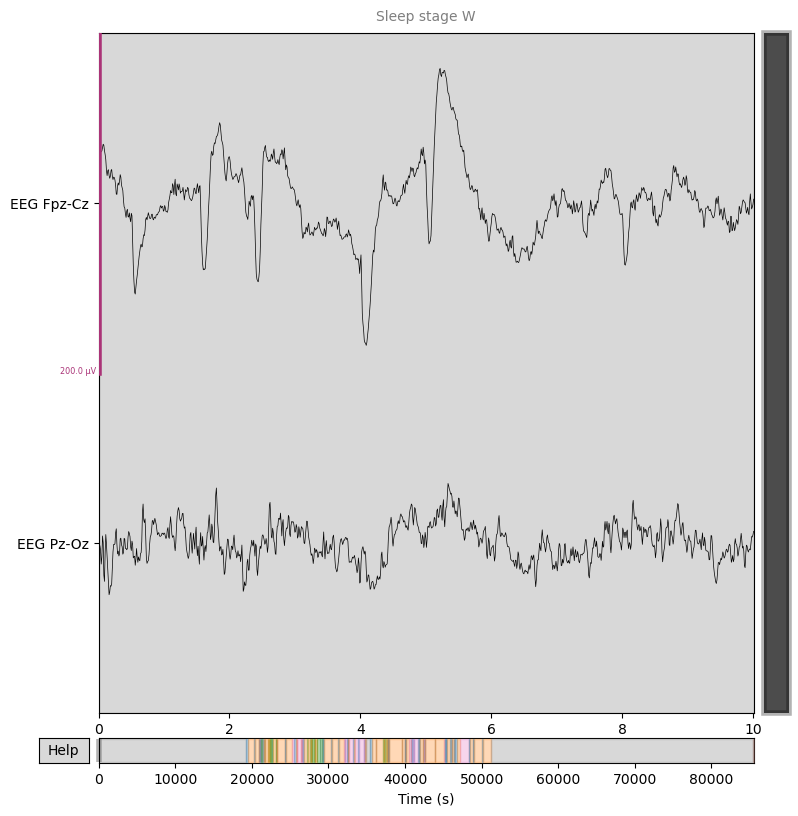

In [24]:
print('\nPlotting our full data in the time domain:\n')
raw.plot(scalings=plot_scalings)
plt.show()

In [25]:
print('Sampling frequency is', raw.info['sfreq'], 'Hz')
sfreq = raw.info['sfreq']

Sampling frequency is 100.0 Hz


In [26]:
print('Assigning the annotations...')
raw_cropped, events, event_id = assign_reduce_annotations(raw, annotations, return_copy=False)

Assigning the annotations...
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Returned cropped MNE object, events and the events id's.


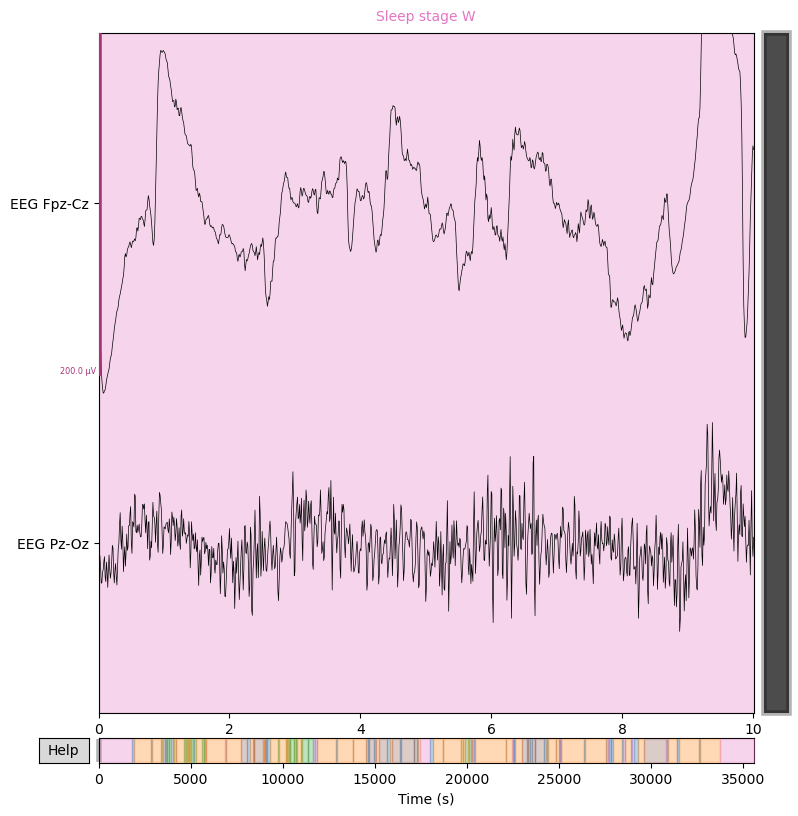

In [27]:
raw_cropped.plot(scalings=plot_scalings)
plt.show()

# Inspection & Visualization


The following figure depicts the annotated sleep events over time: 


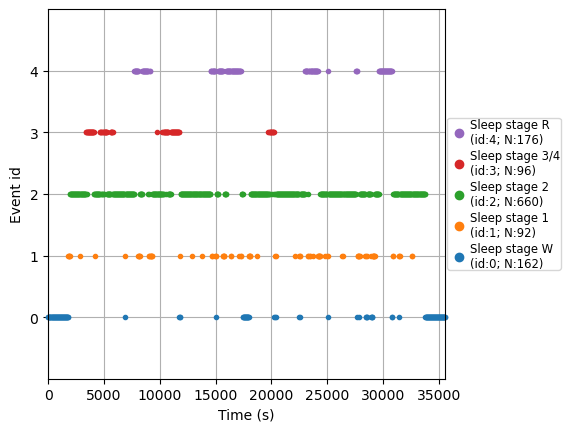

In [28]:
print('\nThe following figure depicts the annotated sleep events over time: ')
fig = mne.viz.plot_events( events, event_id=event_id, sfreq=sfreq, first_samp=events[0, 0])
# fig.savefig('events-all.png', dpi=300, bbox_inches='tight')

In [29]:
print('Cropping the data in order to focus on sleeping time...')
print(f'\nNumber of annotations before cropping: {raw.annotations}')
print(f'Number of annotations after cropping: {raw_cropped.annotations}')

Cropping the data in order to focus on sleeping time...

Number of annotations before cropping: <Annotations | 170 segments: Sleep stage 1 (42), Sleep stage 2 (55), Sleep ...>
Number of annotations after cropping: <Annotations | 170 segments: Sleep stage 1 (42), Sleep stage 2 (55), Sleep ...>


In [30]:
data = raw.get_data(units = 'uV')
print(f'\nFull data shape: {data.shape}')
data_cropped = raw_cropped.get_data(units = 'uV')
print(f'Cropped data shape: {data_cropped.shape}')


Full data shape: (2, 8550000)
Cropped data shape: (2, 3558001)



 The following is the spectrogram of our full data (24hrs):


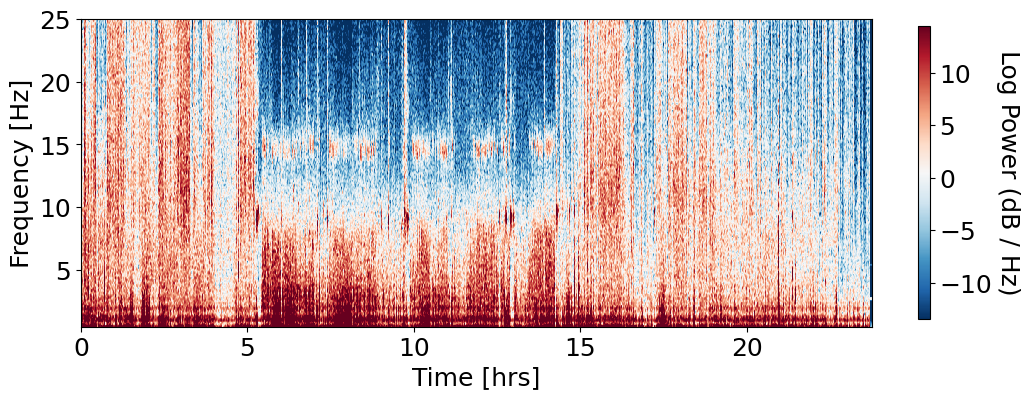


The following is the spectrogram of our cropped data:


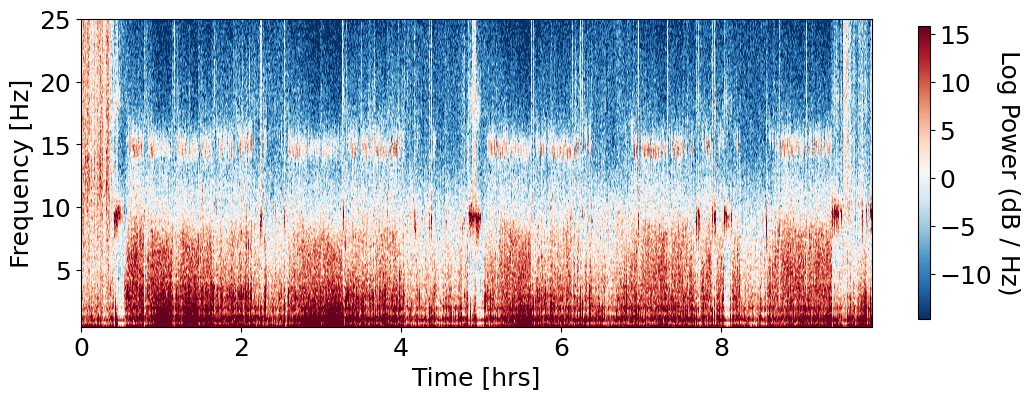

In [31]:
print('\n The following is the spectrogram of our full data (24hrs):')
yasa.plot_spectrogram(data[1], sfreq)
plt.show()

print('\nThe following is the spectrogram of our cropped data:')
yasa.plot_spectrogram(data_cropped[1], sfreq)
plt.show()

### Epoch-ing the EEG data first 

In [32]:
print('Cropping the data to epochs of 30 seconds. In sleep science this time window is chosen.')
epoch_length = 30.0 #seconds
epochs = mne.Epochs(raw_cropped, events, event_id=event_id, tmin=0, tmax=epoch_length-1/sfreq, baseline=None, preload=True )    

labels = epochs.events[:, 2]
label_names = [k for k,v in event_id.items() if v in labels]
print(f'\nData cropped to {labels.size} epochs.')

Cropping the data to epochs of 30 seconds. In sleep science this time window is chosen.
Not setting metadata
1186 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1186 events and 3000 original time points ...
0 bad epochs dropped

Data cropped to 1186 epochs.


In [33]:
print('\n \nCreating labels for each stage.... will be used for plotting.')
stage_map = {v: k for k, v in event_id.items()}
stage_labels = [stage_map[label] for label in labels]
stage_map_reduced = {0: 'W',
                    1: 'N1',
                    2: 'N2',
                    3: 'N3/4',
                    4: 'REM'}


 
Creating labels for each stage.... will be used for plotting.



Below some examples are shown, of 5 different epochs for both channels.


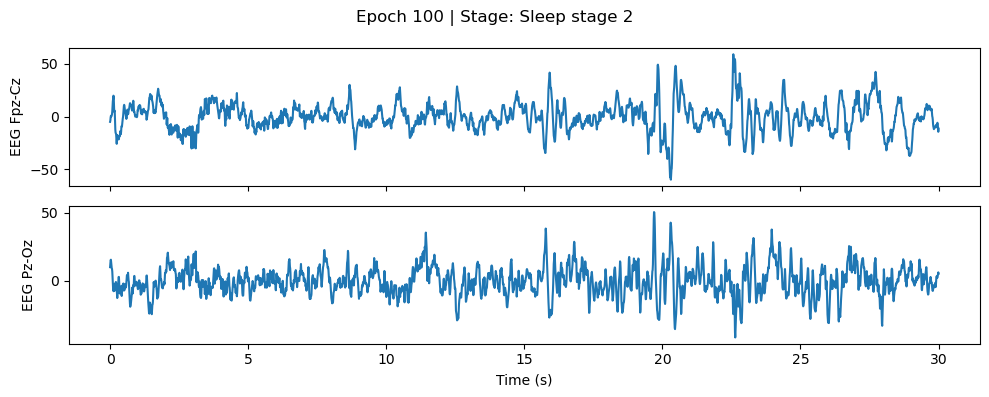

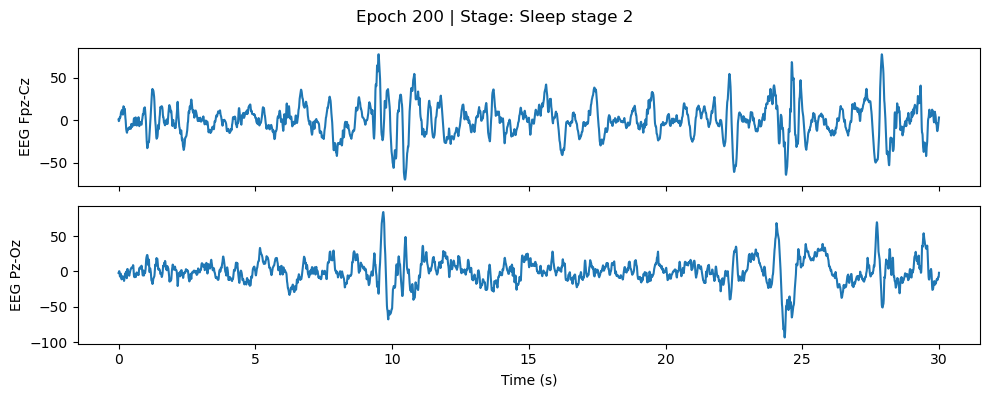

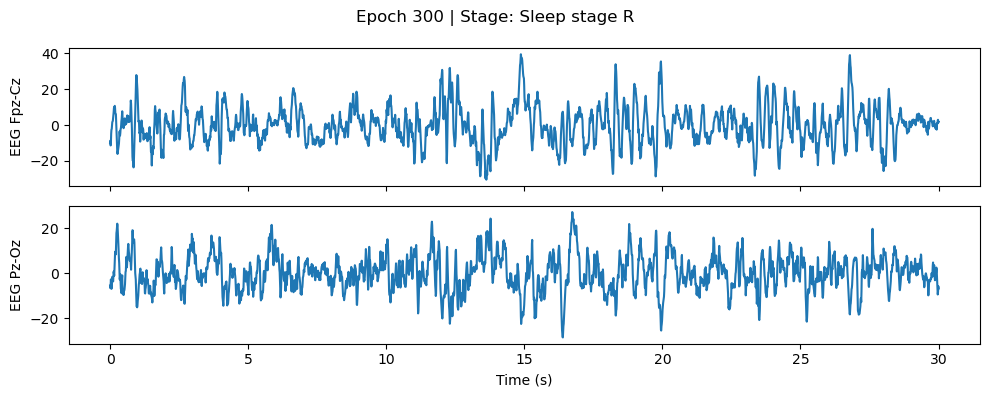

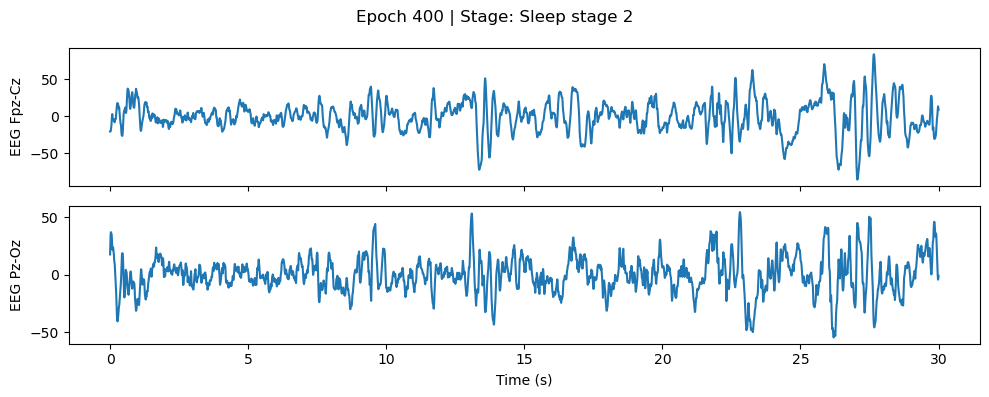

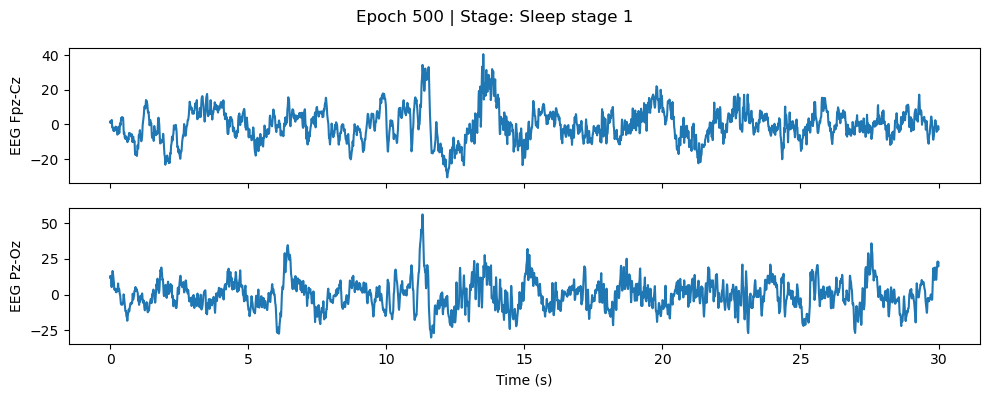

In [34]:
print('\nBelow some examples are shown, of 5 different epochs for both channels.')
data_1 = epochs.get_data(units= 'uV')
sf =int(epochs.info['sfreq'])

for i in [99,199,299,399,499]:
    fig, axs = plt.subplots(2,1, figsize=(10,4), sharex=True)
    time = np.linspace(0,30, data_1.shape[2])
    for ch in range(2):
        axs[ch].plot(time, data_1[i, ch])
        axs[ch].set_ylabel(epochs.ch_names[ch])
    axs[-1].set_xlabel('Time (s)')
    plt.suptitle(f'Epoch {i+1} | Stage: {stage_labels[i]}')
    plt.tight_layout()
    plt.show()
    

# Feature Extraction

In [35]:
# features = [extract_frequency_features(epoch, sfreq) for epoch in epochs.get_data()]
# X_freq = np.array(features)

In [36]:
print('Extracting all features from the dataset...')
X_raw = np.array([extract_all_features(epoch, sf) for epoch in epochs.get_data()])
y = epochs.events[:, 2]  # or use mapped stage_labels if needed
print('All features extracted and target labels are assigned.')

Extracting all features from the dataset...
All features extracted and target labels are assigned.


In [37]:
print(X_raw, '\n\nThis array has shape (number of epochs, number of features):', X_raw.shape) 

[[-2.78870461e-07  4.04365764e-05  7.38533451e-01 ...  1.49511484e-11
   2.16234697e-11  5.55345252e-11]
 [-5.45965600e-07  3.89352056e-05  4.53058721e-01 ...  1.07143370e-11
   4.37262778e-11  8.97457136e-11]
 [ 2.56658712e-07  3.07739577e-05  3.68569762e-02 ...  1.11585597e-11
   2.07048617e-11  5.28032511e-11]
 ...
 [-2.98312447e-07  3.38941778e-05 -4.15134211e-02 ...  8.36894502e-12
   2.00978760e-11  5.00380440e-12]
 [ 3.82299505e-07  3.93893208e-05 -4.28473529e-01 ...  1.16991093e-11
   9.56755228e-12  1.49620648e-11]
 [ 3.95991431e-07  4.40560990e-05  2.05207085e-01 ...  1.08725078e-11
   6.46580022e-11  1.80603117e-11]] 

This array has shape (number of epochs, number of features): (1186, 22)


In [38]:
# creating a dataframe to easily view which feature is which.
time_features = ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'ptp', 'zero_crossings']
freq_features = ['delta_power', 'theta_power', 'alpha_power', 'beta_power']
all_features = time_features + freq_features
channel_names = epochs.info['ch_names']
column_names = []

for ch in channel_names:
    for feature in all_features:
        column_names.append(f'{ch} {feature}')

df = pd.DataFrame(X_raw, columns=column_names)
print('\nShowing the first 5 rows...')
print(df.head(), '\n\n')


Showing the first 5 rows...
   EEG Fpz-Cz mean  EEG Fpz-Cz std  EEG Fpz-Cz skewness  EEG Fpz-Cz kurtosis  \
0    -2.788705e-07        0.000040             0.738533             1.975571   
1    -5.459656e-07        0.000039             0.453059             1.380448   
2     2.566587e-07        0.000031             0.036857             2.362043   
3    -2.940000e-07        0.000034             0.096111             0.379092   
4     3.023864e-07        0.000028            -0.236904             1.253073   

   EEG Fpz-Cz rms  EEG Fpz-Cz ptp  EEG Fpz-Cz zero_crossings  \
0        0.000040        0.000281                       94.0   
1        0.000039        0.000264                      118.0   
2        0.000031        0.000237                      123.0   
3        0.000034        0.000212                      103.0   
4        0.000028        0.000189                      124.0   

   EEG Fpz-Cz delta_power  EEG Fpz-Cz theta_power  EEG Fpz-Cz alpha_power  \
0            6.309163e-08   

# Analysis

In [39]:
print('We start the analysis by normalizing the data. The StandardScaler is used...')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
print('Dataset scaled.\n')

We start the analysis by normalizing the data. The StandardScaler is used...
Dataset scaled.



## Dimensionality Reduction

### PCA

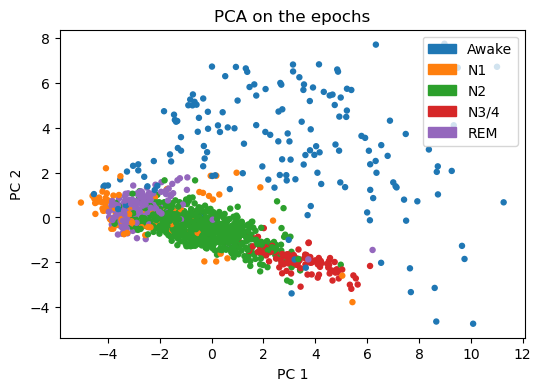

PCA components' matrix shape: (2, 22)


In [40]:
# pca - 2 for visualization
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)
from sklearn.metrics import classification_report
plt.figure(figsize=(6,4))
sc = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, cmap=cmap, s=13)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA on the epochs')

plt.legend(handles=patches, loc='upper right')
saveplot('PCA-2.png')
plt.show()

print(f'PCA components\' matrix shape: {pca2.components_.shape}')

In [41]:
pd.DataFrame(pca2.components_.round(3), columns=column_names)

,EEG Fpz-Cz mean,EEG Fpz-Cz std,EEG Fpz-Cz skewness,EEG Fpz-Cz kurtosis,EEG Fpz-Cz rms,EEG Fpz-Cz ptp,EEG Fpz-Cz zero_crossings,EEG Fpz-Cz delta_power,EEG Fpz-Cz theta_power,EEG Fpz-Cz alpha_power,...,EEG Pz-Oz std,EEG Pz-Oz skewness,EEG Pz-Oz kurtosis,EEG Pz-Oz rms,EEG Pz-Oz ptp,EEG Pz-Oz zero_crossings,EEG Pz-Oz delta_power,EEG Pz-Oz theta_power,EEG Pz-Oz alpha_power,EEG Pz-Oz beta_power
0,0.020,0.336,0.011,-0.053,0.336,0.310,-0.265,-0.015,0.308,-0.028,...,0.283,-0.015,0.300,0.269,0.199,0.115,0.263,0.133,0.131,0.109
1,-0.033,0.173,-0.068,0.143,0.173,0.207,-0.076,0.029,-0.219,-0.069,...,-0.141,0.489,0.195,0.038,-0.129,-0.105,-0.292,-0.341,0.284,0.394


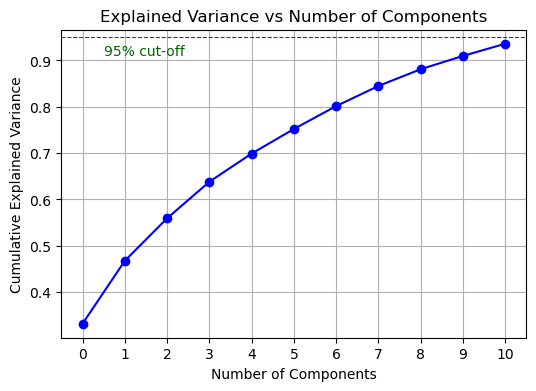

Reconstruction Error (MSE): 0.063993

Principal Components:
                             PC1    PC2    PC3    PC4    PC5    PC6    PC7  \
EEG Fpz-Cz mean            0.020 -0.033  0.049 -0.014 -0.057 -0.328  0.677   
EEG Fpz-Cz std             0.336  0.173 -0.135 -0.084  0.117 -0.040  0.004   
EEG Fpz-Cz skewness        0.011 -0.068  0.142  0.146  0.091 -0.427 -0.421   
EEG Fpz-Cz kurtosis       -0.053  0.143  0.434  0.107  0.384 -0.182 -0.139   
EEG Fpz-Cz rms             0.336  0.173 -0.135 -0.084  0.117 -0.040  0.004   
EEG Fpz-Cz ptp             0.310  0.207  0.042  0.002  0.242 -0.092 -0.033   
EEG Fpz-Cz zero_crossings -0.265 -0.076  0.212  0.287 -0.031  0.051  0.077   
EEG Fpz-Cz delta_power    -0.015  0.029 -0.037  0.005  0.228  0.594 -0.331   
EEG Fpz-Cz theta_power     0.308 -0.219  0.193 -0.088 -0.199  0.050 -0.053   
EEG Fpz-Cz alpha_power    -0.028 -0.069 -0.026 -0.178  0.177  0.461  0.338   
EEG Fpz-Cz beta_power      0.046  0.004  0.485 -0.016  0.409  0.101  0.200   
EEG 

In [42]:
do_pca(X_scaled, y, feature_names=column_names, max_components=11, filename='pca-expl-var.png')

In [43]:
pca10 = PCA(n_components=10)
X_pca10 = pca10.fit_transform(X_scaled)

### LDA

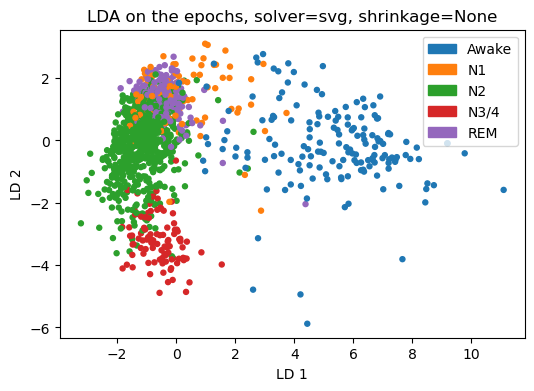

In [44]:
# lda - 2 for visualization
lda2 = LDA(n_components=2)
X_lda2 = lda2.fit_transform(X_scaled, y)

plt.figure(figsize=(6,4))
sc = plt.scatter(X_lda2[:, 0], X_lda2[:, 1], c=y, cmap=cmap, s=13)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('LDA on the epochs, solver=svg, shrinkage=None')
plt.legend(handles=patches,  loc='upper right')
saveplot('LDA-2.png')
plt.show()

In [45]:
# lda - 4 
lda4 = LDA(n_components=4)
X_lda4 = lda4.fit_transform(X_scaled, y)


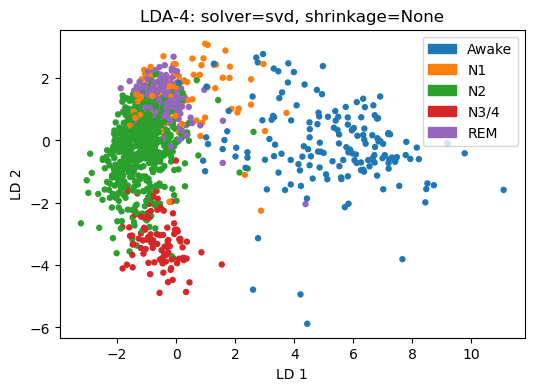

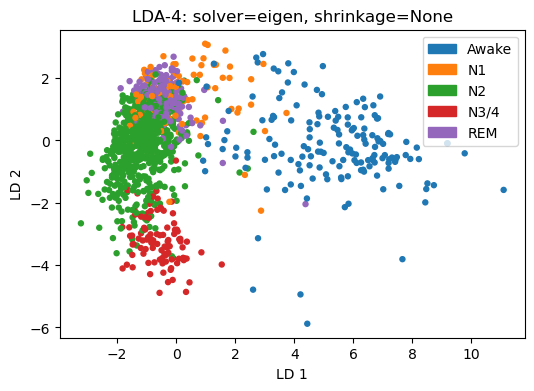

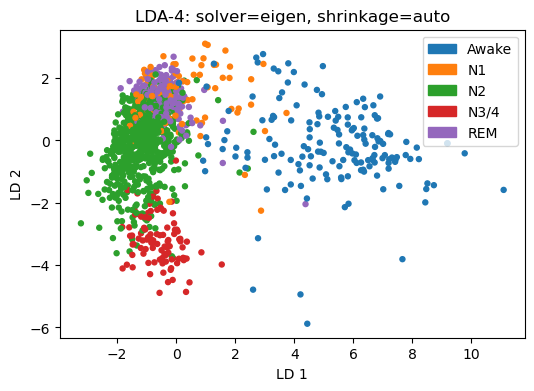

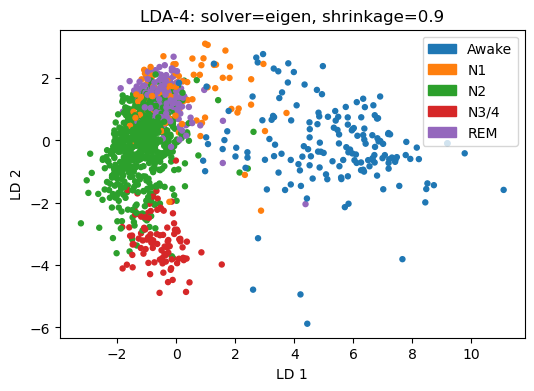

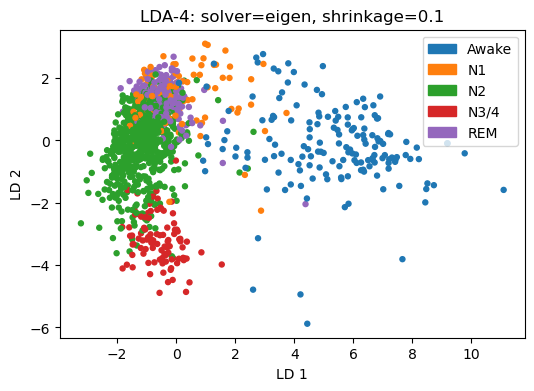

In [46]:
# lda - 4 for eigen solver and shrinkage visualixation
solvers = ['svd', 'eigen']
shrinkages = [None,'auto', 0.9, 0.1]

for solver in solvers:
    for shrink in shrinkages:
        if solver == 'svd' and shrink != None:
            continue  # shrinkage not supported for svd
        # lda4 = LDA(n_components=4, solver=solver, shrinkage=shrink if solver != 'svd' else None)
        # X_lda4 = lda4.fit_transform(X_scaled, y)

        plt.figure(figsize=(6,4))
        sc = plt.scatter(X_lda4[:, 0], X_lda4[:, 1], c=y, cmap=cmap, s=13)
        plt.xlabel('LD 1')
        plt.ylabel('LD 2')
        plt.title(f'LDA-4: solver={solver}, shrinkage={shrink}')
        plt.legend(handles=patches,  loc='upper right')


        filename = f'LDA-4-{solver}-shrink-{shrink}.png'.replace(' ', '')
        saveplot(filename)
        plt.show()

## Naive Bayes

#### Gaussian

In [47]:
# training and testing gnb on the different datasets
print('We now train and test Gaussian Naive Bayes models as classifiers in different datasets.')

sets_for_gnb = [X_pca2, X_pca10, X_lda2]
set_names = ['PCA-2', 'PCA-10', 'LDA-2']

gnb_results = []

for s, name in zip(sets_for_gnb, set_names):
    X_train, X_test, y_train, y_test = train_test_split(
        s, y, test_size=0.3, random_state=42, stratify=y
    )    
    
    gnb = train_naive_bayes(X_train, y_train)
    y_pred = gnb.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')  # calculating for each class individually
    f1 = f1_score(y_test, y_pred, average='macro')    

    cm = confusion_matrix(y_test, y_pred)

    gnb_results.append({
        'name': name,
        'model': gnb,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    })
    print('---------------------------------------------------------------')
    print('GNB', name)
    print(classification_report(y_test, y_pred, target_names=stage_map_reduced.values()))
    print('---------------------------------------------------------------')

for result in gnb_results:
    print(f" {result['name']}: Accuracy = {result['accuracy']:.2f}, Recall = {result['recall']:.2f}, F1 = {result['f1_score']:.2f}")
print('\n\n---------------------------------------------------------------')

We now train and test Gaussian Naive Bayes models as classifiers in different datasets.
---------------------------------------------------------------
GNB PCA-2
              precision    recall  f1-score   support

           W       0.89      0.82      0.85        49
          N1       0.00      0.00      0.00        27
          N2       0.89      0.91      0.90       198
        N3/4       0.68      0.86      0.76        29
         REM       0.63      0.85      0.73        53

    accuracy                           0.81       356
   macro avg       0.62      0.69      0.65       356
weighted avg       0.77      0.81      0.79       356

---------------------------------------------------------------
---------------------------------------------------------------
GNB PCA-10
              precision    recall  f1-score   support

           W       0.77      0.90      0.83        49
          N1       0.47      0.26      0.33        27
          N2       0.97      0.88      0.92    

#### Attempt on other Bayes method

In [48]:
from empiricaldist import Pmf

## Surprise classifier (GMM)

#### GMMs

In [49]:
# training and testing GMMs on different datasets...
print('We now train and test Gaussian Mixture Models as classifiers in different datasets.')
sets_for_gmm = [X_pca2, X_pca10, X_lda2]
set_names = ['PCA-2', 'PCA-10', 'LDA-2']

gmm_results = []

for s, name in zip(sets_for_gmm, set_names):
    X_train, X_test, y_train, y_test = train_test_split(s, y, test_size=0.3, random_state=42, stratify=y)
    
    
    gmms = train_gmm_classifier(X_train, y_train)
    y_pred = predict_gmm(X_test, gmms)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred,average='macro')
    cm = confusion_matrix(y_test, y_pred)

    gmm_results.append({
        'name': name,
        'gmms': gmms,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    })
    print('---------------------------------------------------------------')
    print('GMM', name)
    print(classification_report(y_test, y_pred, target_names=stage_map_reduced.values()))
    print('---------------------------------------------------------------')    
    
for result in gmm_results:
    print(f"{result['name']}: Accuracy = {result['accuracy']:.2f}, Recall = {result['recall']:.2f}, F1 = {result['f1_score']:.2f}")
print('\n\n---------------------------------------------------------------')

We now train and test Gaussian Mixture Models as classifiers in different datasets.
---------------------------------------------------------------
GMM PCA-2
              precision    recall  f1-score   support

           W       0.83      0.88      0.85        49
          N1       0.28      0.19      0.22        27
          N2       0.95      0.75      0.84       198
        N3/4       0.63      0.90      0.74        29
         REM       0.56      0.92      0.70        53

    accuracy                           0.76       356
   macro avg       0.65      0.73      0.67       356
weighted avg       0.80      0.76      0.76       356

---------------------------------------------------------------
---------------------------------------------------------------
GMM PCA-10
              precision    recall  f1-score   support

           W       0.81      0.88      0.84        49
          N1       0.34      0.37      0.36        27
          N2       0.97      0.86      0.91       1

In [50]:
from matplotlib.patches import Ellipse

def plot_gmm_components_per_class(result, title=None, class_labels=None, k=2.):
    """
    Visualize each class-specific GMM in a 2D feature space.
    Assumes the data is already 2D (PCA or LDA reduced).
    """
    fig, axes = plt.subplots(1, len(result['gmms']), figsize=(5 * len(result['gmms']), 4))
    if len(result['gmms']) == 1:
        axes = [axes]

    for i, (gmm, ax) in enumerate(zip(result['gmms'], axes)):
        label = CLASS_ORDER[i]
        label_name = class_labels[i] if class_labels else f"Class {label}"        
        X_class = result['X_train'][result['y_train'] == label]
        
        ax.scatter(X_class[:, 0], X_class[:, 1], s=10, alpha=0.7, label=label_name, color=COLORS[i])

        for j in range(gmm.n_components):
            mean = gmm.means_[j]
            cov = gmm.covariances_[j]

            if cov.shape[0] > 2:
                cov = cov[:2, :2]  # slice to 2D

            v, w = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))
            v = k * np.sqrt(v)  #depicting k standard deviations
            ell = Ellipse(xy=mean[:2], width=v[0], height=v[1], angle=angle,
                          edgecolor='black', facecolor='none', linewidth=1.5)
            ax.add_patch(ell)

        ax.set_title(f'{label_name}')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.legend()

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


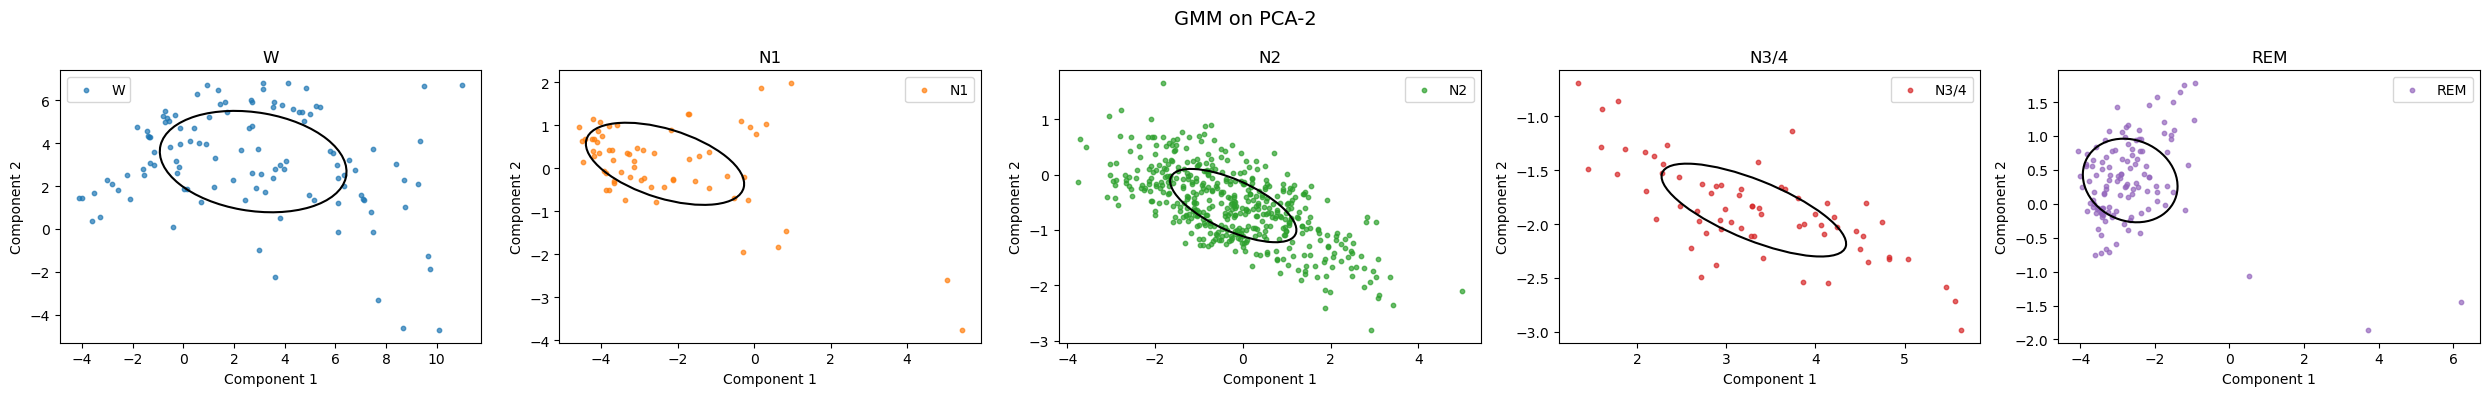

In [51]:
plot_gmm_components_per_class(gmm_results[0], title="GMM on PCA-2", 
                              class_labels=list(stage_map_reduced.values()))


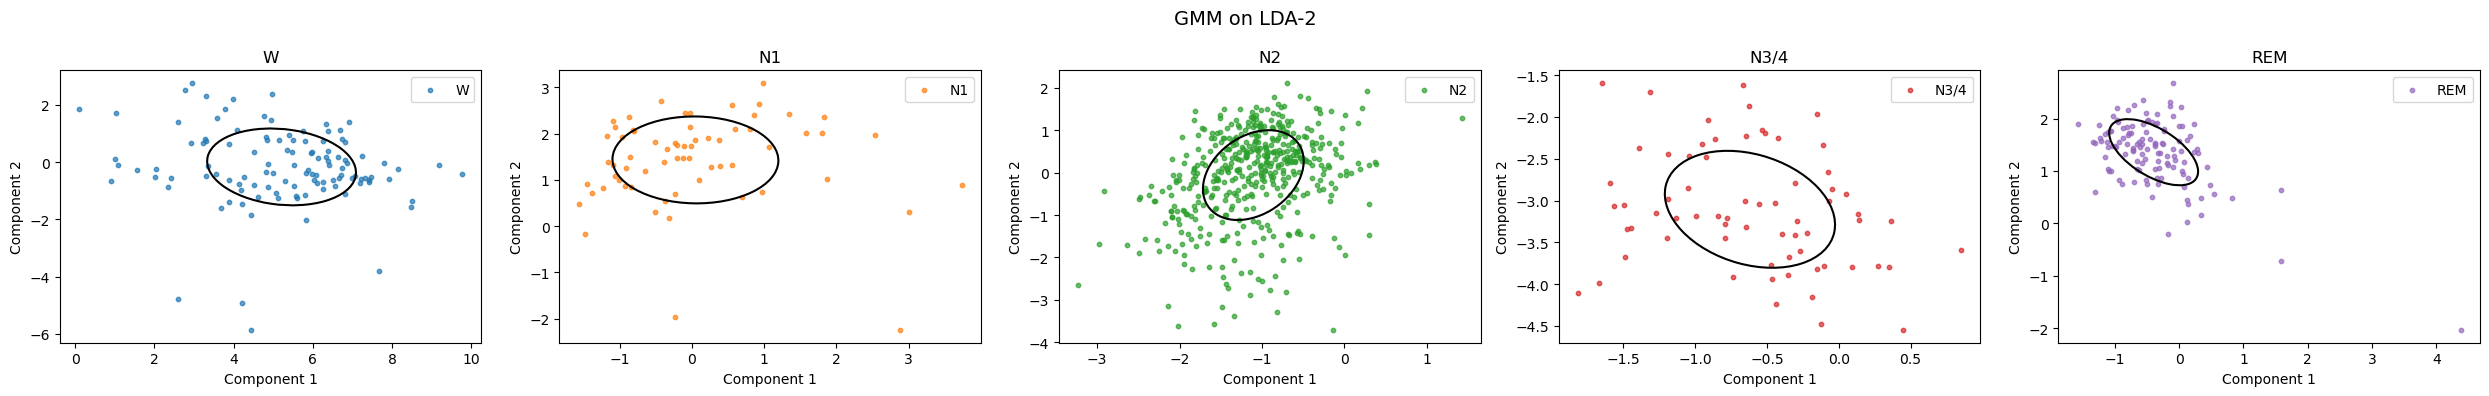

In [52]:
plot_gmm_components_per_class(gmm_results[2], title="GMM on LDA-2", 
                              class_labels=list(stage_map_reduced.values()))


# Comparisons & Conclusion

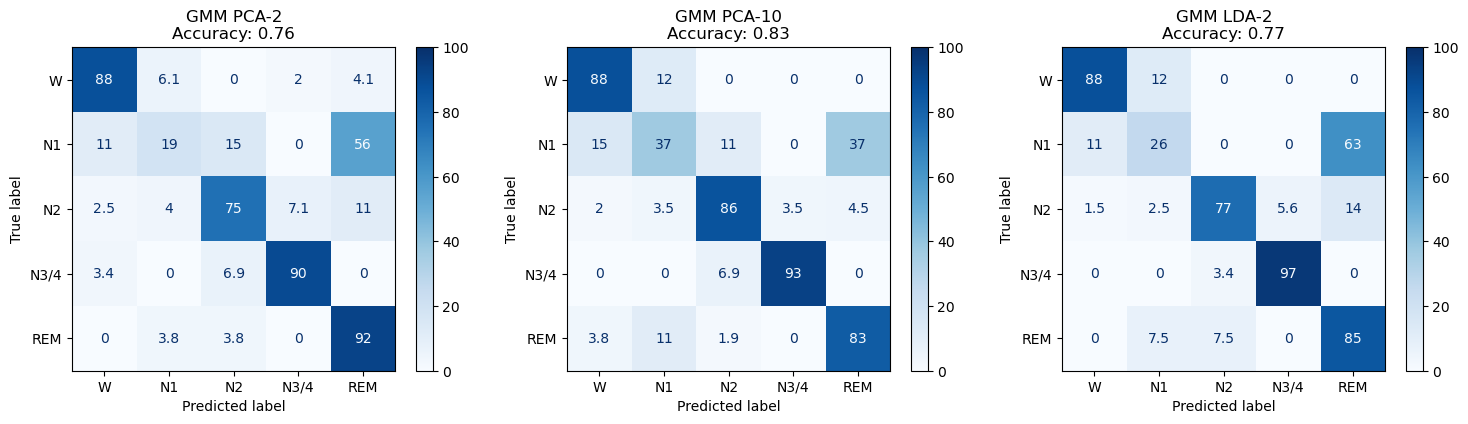

In [53]:
# plotting gmm results...
plot_confusion_matrices_from_results(gmm_results, display_labels=list(stage_map_reduced.values()), 
                                     title_prefix='GMM')

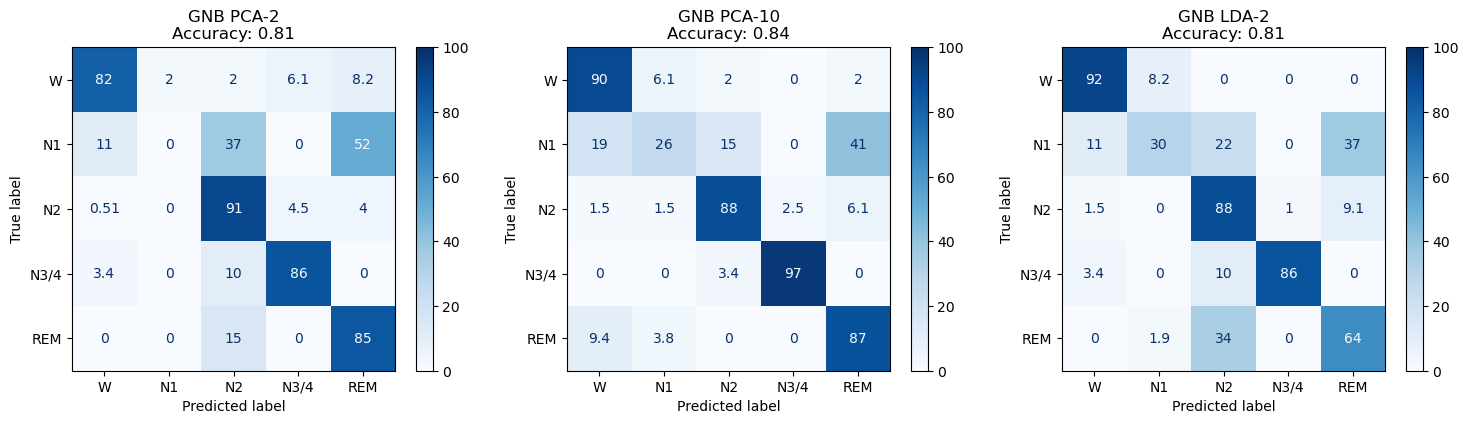

In [54]:
# plotting gnb results...
plot_confusion_matrices_from_results(gnb_results, display_labels=list(stage_map_reduced.values()), 
                                     title_prefix='GNB')

In [55]:
# plotting the winner...
# plot_single_confusion_from_result(gmm_results[1], display_labels=list(stage_map_reduced.values()), 
                                  # title='GMM PCA-10')